$ \theta = \{\psi, \sigma \} $

$\psi$: Parametros para definição do modelo que será utilizado em cada estado<br>
$\sigma$: Parametros para cada Modelo $\{\sigma_1, \sigma_2, ...\}$ <br>

$ \beta: S \mapsto [0,1]^k \;\; onde \;\; k = |\sigma|$ <br>
$ \beta(s; \psi)_i = p_{\psi}(\sigma_i | s) \; \forall \; i \in (1, 2, ..., k)$ <br>
A função $ \beta $ define a probabilidade de cada parametro em $ \sigma $ ser o modelo utilizado pra gerar a transição em um estado <br>

$\mu: S \times S \times A \times \sigma \mapsto [0,1] $ <br>
$\mu(s', s, a, \sigma_x)= p_{\sigma_x}(s'|s,a)$ <br>
A função $ \mu $ define a probabilidade de transição para um estado, dado um par de estado e ação, seguindo o modelo $\sigma_x$ <br>

In [1]:
import numpy as np
import random

force = .5
actions = np.array([(force,0), (-force,0), (0,force), (0,-force)])
theta = [5, (.005,.3)]

def mu(s, a, p=2):
    acts = actions[a]
    return s + acts + np.random.normal(0, p, 2)

def beta(x,y):
    psi, _ = theta
    return 1*((x**2 + y**2)**(1/2) < psi)

def generate(s0, n):   
    _, sigma = theta
    s = s0
    for _ in range(n):
        a = np.random.choice(4, 1)[0]
        m = beta(s[:,0], s[:,1])[0]
        sa = np.insert(s, s.size, a)
        yield np.insert(sa, sa.size, m)
        s = mu(s, a, sigma[m])

# def trajectory(s_0=(1,1), n=100):
#     gen = generate(s_0, n)
#     return np.fromiter(gen, dtype=np.dtype((float, 4)))

# s_0 = np.array([[0,0]])
# n = 1000

# O = trajectory(s_0, n)
# O[:] # all
# O[:,0:2] # states
# O[:,2] # actions
# O[:,3] # hidden models


In [2]:
import pandas as pd

def generate_data(trajectory_size=1000, n_trajectories=10, s_0=(0,0)):
    s_0 = np.array([s_0])
    gen = generate(s_0, 1)
    sx,sy,a,m = next(gen)
    df = pd.DataFrame({
        'n':[0],
        't':[0],
        's':[(sx,sy)],
        'a':[int(a)],
        'm':[int(m)]
        })

    for i in range(n_trajectories):
        gen = generate(s_0, trajectory_size)
        for t,(sx,sy,a,m) in enumerate(gen):
            df.loc[len(df.index)] = [int(i),int(t),(sx,sy),int(a),int(m)]

    df.drop(0, inplace=True)
    return df

df = generate_data() 
df.head()

,n,t,s,a,m
1,0,0,"(0, 0)",0,1
2,0,1,"(0.941551485423145, -0.0839827833206286)",2,1
3,0,2,"(1.3081370823653653, -0.06316063433274999)",2,1
4,0,3,"(1.222668013232718, 0.24173181956996456)",3,1
5,0,4,"(0.8482228385054704, -0.7254063978304337)",3,1


<AxesSubplot: >

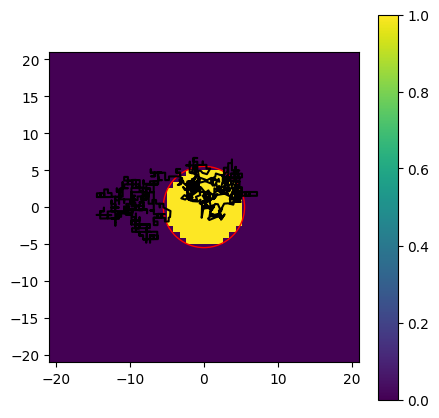

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_trajectory(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    # ax.invert_yaxis()

    size = 20
    res = 50
    x = np.linspace(-size, size, res).reshape(-1,1)
    y = np.linspace(-size, size, res).reshape(-1,1)

    X,Y = np.meshgrid(x,y)
    p = ax.imshow(beta(X,Y), extent=(int(min(x))-1, int(max(x))+1, int(max(y))+1, int(min(y))-1), vmin = 0, vmax = 1)
    plt.colorbar(p)
    ax.invert_yaxis()

    df_s = pd.DataFrame(data.s.to_list(), columns=['x','y'])
    ax.plot(df_s.x, df_s.y, color='black')
    ax.add_patch(Circle((0, 0), theta[0]+force, edgecolor='red', fill=False))
    return ax

plot_trajectory(df[df.n==0])

In [4]:
import torch
from torch.autograd import Variable
from torch.distributions import normal
import torch.nn as nn
import torch.nn.functional as f

class BetaModel(nn.Module):
    def __init__(self):
        super(BetaModel, self).__init__()
        n_features = 2
        n_models = 2
        n_hidden = 10

        self.model = nn.Sequential(
            nn.Linear(n_features, n_hidden).double(),
            nn.ReLU(),
            # nn.Linear(n_hidden, n_hidden).double(),
            # nn.ReLU(),
            nn.Linear(n_hidden, n_models).double(),
            nn.ReLU(),
            # nn.Softmax(dim=1)
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)

In [41]:

def train(model, data, epochs=1000):
    x_train_tensor = torch.tensor(data.s.to_list()).type(torch.DoubleTensor)
    y_train_tensor = torch.from_numpy(np.array(data.m)).type(torch.LongTensor)

    optim = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=.9)
    # loss = nn.MSELoss(reduction='mean')
    # loss = nn.CrossEntropyLoss()
    loss = nn.NLLLoss(reduction='sum')

    def do_train():
        optim.zero_grad()
        outputs = model(x_train_tensor)
        ll = loss(outputs, y_train_tensor)
        # print(ll)
        # if ll.data == torch.inf or torch.isnan(ll.data):
        #     break
        ll.backward()
        optim.step() 
        return ll

    model.train(True)
    lls = [do_train().item() for _ in range(epochs)]
    model.train(False)

    return lls


torch.manual_seed(1)
def train_models(data, n_models=10):
    models = [BetaModel() for _ in range(n_models)]
    results = [train(model, data) for model in models]
    return models, results
mod, res = train_models(df[df.n==0], 1)
res

[[693.082804949349,
  693.0814243915291,
  693.0788038186763,
  693.0750717575107,
  693.0703455219842,
  693.0639364033935,
  693.0554376034356,
  693.0456488585635,
  693.0347163384538,
  693.0227728786239,
  693.0099390159921,
  692.9963239747906,
  692.9810284038214,
  692.9616096857986,
  692.9409473495932,
  692.9192051810601,
  692.8965313363041,
  692.8730596192244,
  692.8489106847003,
  692.8207373533309,
  692.786361128512,
  692.7481655586103,
  692.7021178717347,
  692.6377512943864,
  692.5618687772638,
  692.4662413460775,
  692.3522817682424,
  692.1772441141026,
  691.9742502949621,
  691.7427702545904,
  691.4803378685756,
  691.1479246925496,
  690.76246217218,
  690.3262188576814,
  689.821963591773,
  689.1913146620892,
  688.5118784664265,
  687.7317301972437,
  686.8557818987994,
  685.9071396984226,
  684.7854995736527,
  683.1897460633469,
  682.1102379458863,
  681.8129876633691,
  681.7372272538747,
  681.4743382064447,
  680.8598878389125,
  679.901176257899

In [43]:
def train_models(data, n_models=10):
    models = [BetaModel() for _ in range(n_models)]
    results = [train(model, data) for model in models]
    return models, results

n = 10 
m = 5
models = []
results = []
for i in range(n):
    mod, res = train_models(df[df.n==i], m)
    models.append(mod)
    results.append(res)

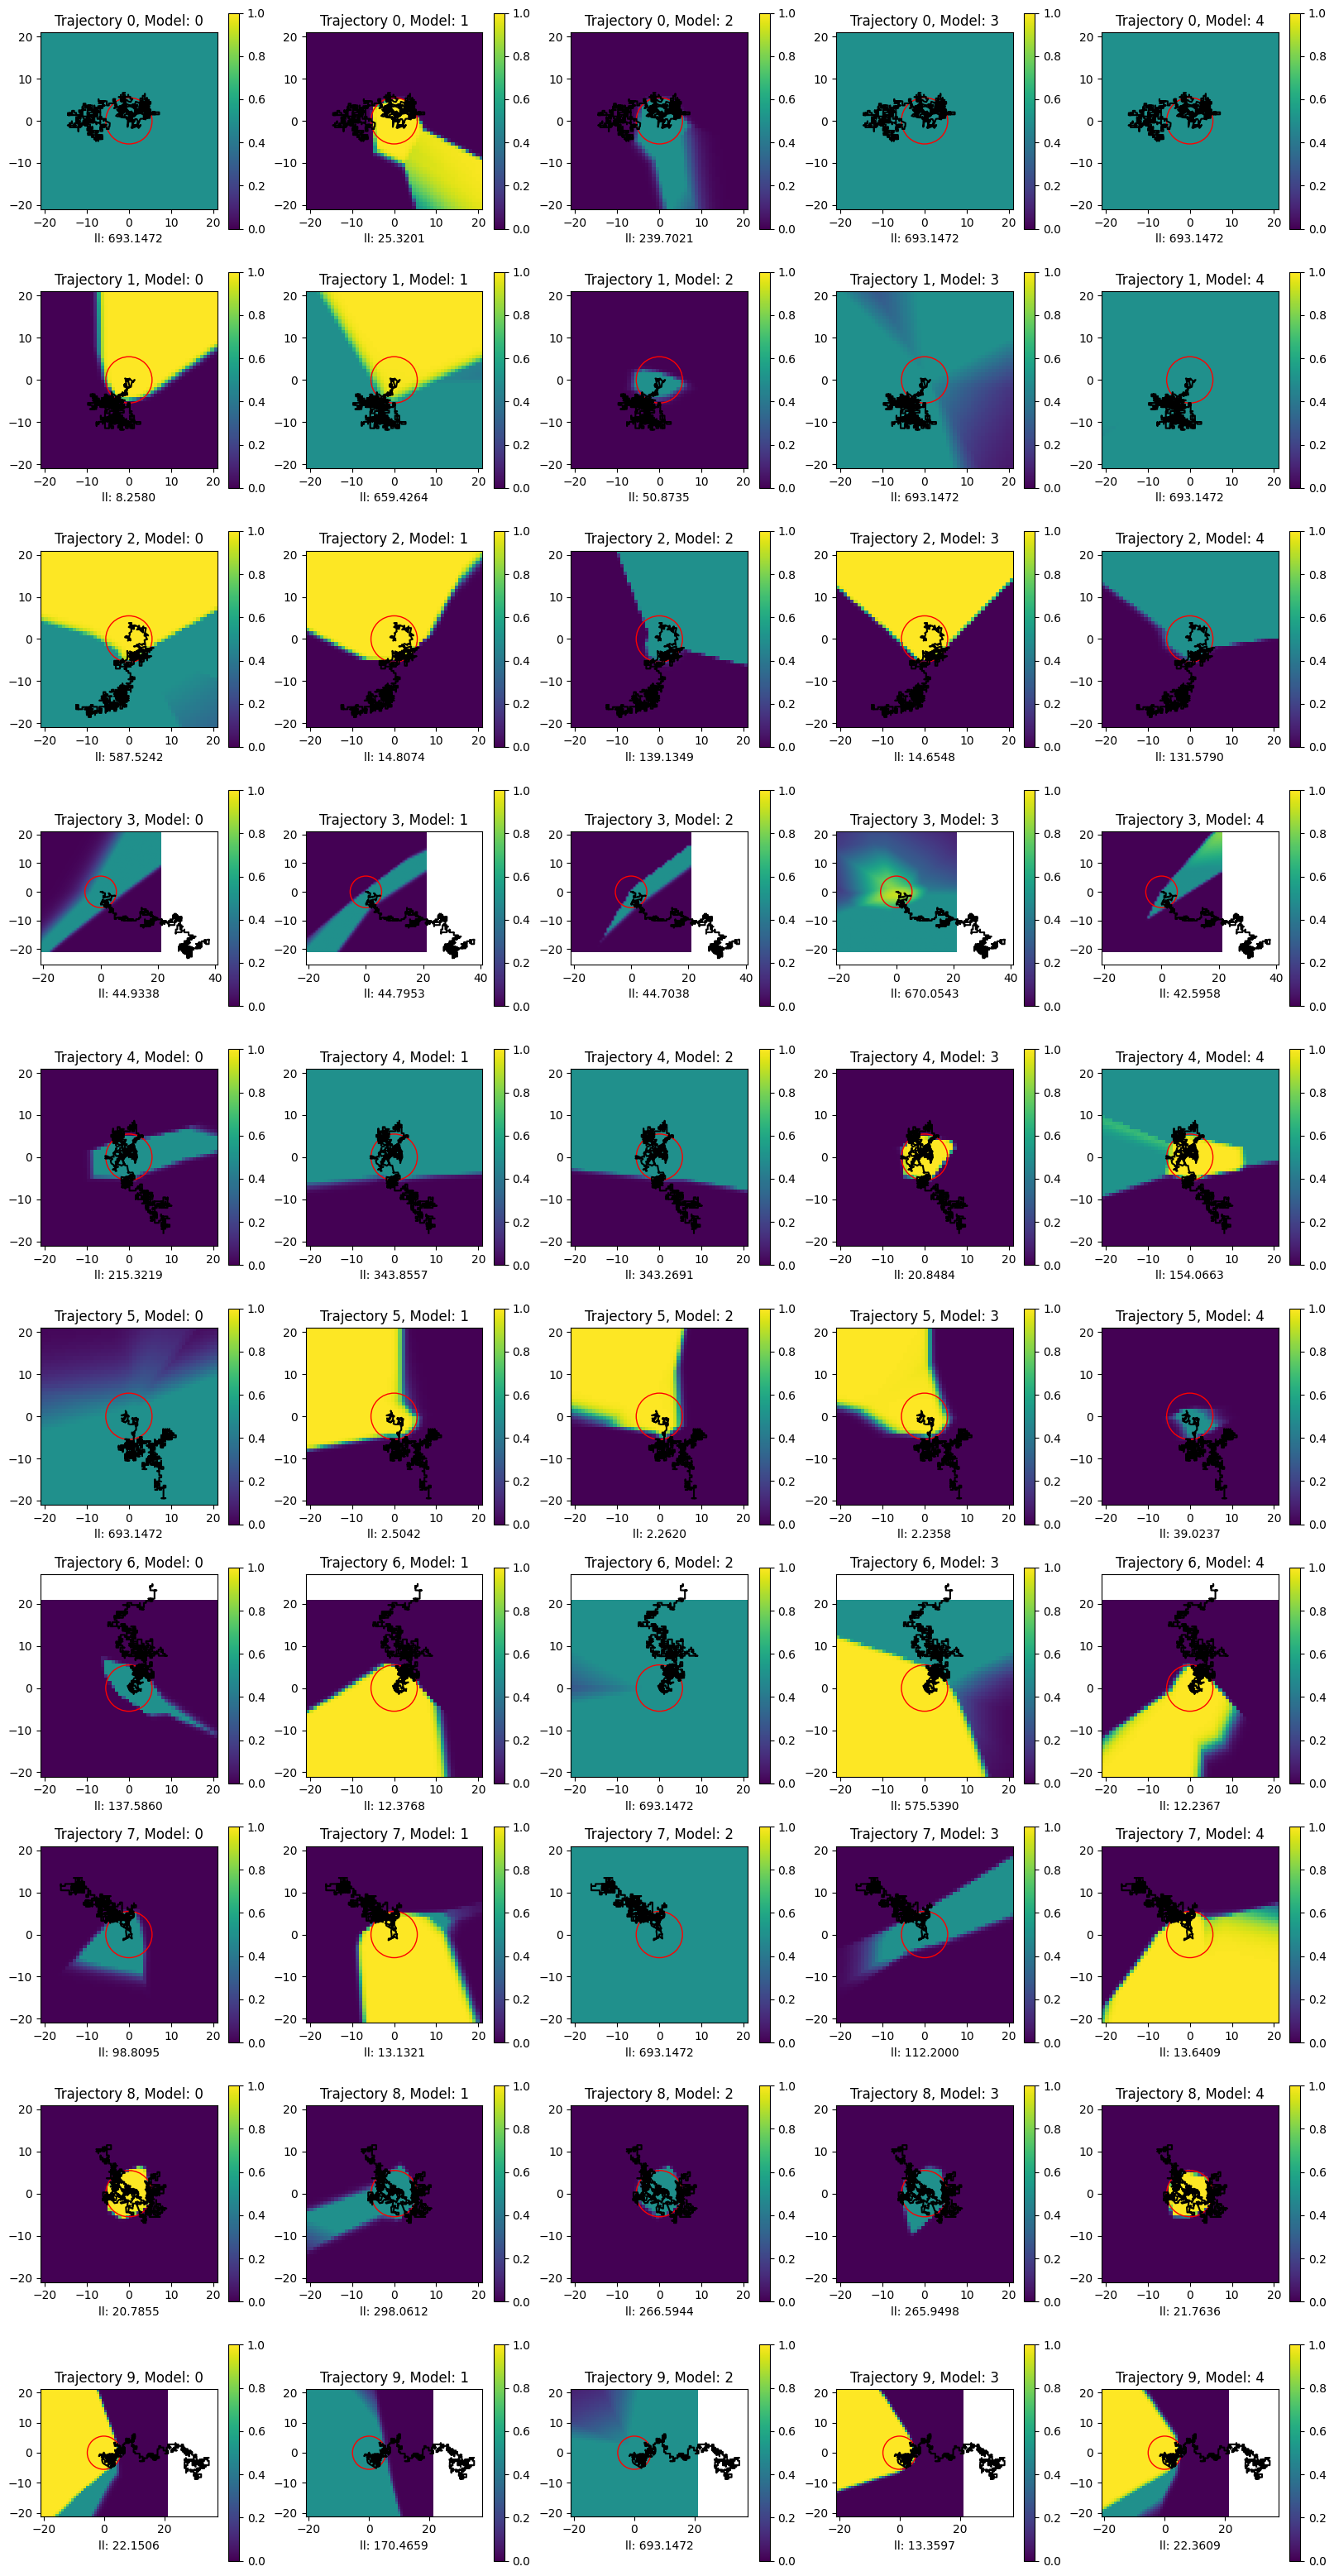

In [44]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_test(data, t=None, n=None):
    if t is None:
        ts = range(len(models))
    else:
        ts = [t]

    if n is None:
        ms = range(len(models[ts[0]]))
    else:
        ms = [n]

    # fig = plt.figure(1, figsize=(5, 5*len(ms)))
    fig, axs = plt.subplots(len(ts), len(ms), figsize=(4*len(ms), (4*len(ts))))
    if len(ts)==1:
        axs = [axs]
    if len(ms)==1:
        axs = [axs]

    
    size = 20
    res = 50
    lin = np.linspace(-size, size, res).reshape(-1,1)
    X,Y = np.meshgrid(lin, lin)

    d = np.stack((X, Y), axis=-1).reshape(-1, 2)
    d = torch.from_numpy(d).type(torch.DoubleTensor)
    
    for row, t in zip(axs, ts):
        df_s = pd.DataFrame(data[data.n==t].s.to_list(), columns=['x','y'])
        
        for ax, m in zip(row, ms):
            ax.set_title(f'Trajectory {t}, Model: {m}')
            corr = torch.exp(models[t][m](d))[:,1].reshape(int(X.size**(1/2)), int(X.size**(1/2)))
            with torch.no_grad():
                p = ax.imshow(corr, extent=(int(min(lin))-1, int(max(lin))+1, int(max(lin))+1, int(min(lin))-1), vmin = 0, vmax = 1)
                plt.colorbar(p)
            ax.invert_yaxis()
            ax.set_xlabel(f'll: {results[t][m][-1]:.4f}')
            ax.plot(df_s.x, df_s.y, color='black')
            ax.add_patch(Circle((0, 0), theta[0]+force, edgecolor='red', fill=False))



plot_test(df)
# plot_test(df, 0)
# plot_test(df, 0,0)

In [45]:
df_results = pd.DataFrame({
    "n": [i for i,values in enumerate(results) for _ in values],
    "nn": [j for _,values in enumerate(results) for j,_ in enumerate(values)],
    # "ll": [v.item() for values in results for v in values],
    "ll": [v[-1] for values in results for v in values],
    # "ll_ideal": [nn.NLLLoss(reduction='sum')(
    #         torch.log_softmax(torch.from_numpy(np.stack((1-df[df.n==i].m, df[df.n==i].m), axis=-1)).type(torch.DoubleTensor), dim=-1),
    #         torch.from_numpy(np.array(df[df.n==i].m)).type(torch.LongTensor)
    #     ).item() for i,values in enumerate(results) for j,v in enumerate(values)],
    "ll_const": [nn.NLLLoss(reduction='sum')(
            torch.log_softmax(torch.from_numpy(np.stack((np.ones(df[df.n==i].shape[0]), np.zeros(df[df.n==i].shape[0])), axis=-1)).type(torch.DoubleTensor), dim=-1),
            torch.from_numpy(np.array(df[df.n==i].m)).type(torch.LongTensor)
        ).item() for i,values in enumerate(results) for _,_ in enumerate(values)],
})

df_results.head(10)

,n,nn,ll,ll_const
0,0,0,693.147181,627.261688
1,0,1,25.320108,627.261688
2,0,2,239.702085,627.261688
3,0,3,693.147181,627.261688
4,0,4,693.147181,627.261688
5,1,0,8.258042,370.261688
6,1,1,659.426432,370.261688
7,1,2,50.873468,370.261688
8,1,3,693.147181,370.261688
9,1,4,693.147181,370.261688


In [46]:
df_results[['n', 'll']].groupby('n').agg(['mean', 'median', 'std', 'min', 'max'])

ll                                               
         mean      median         std        min         max
n                                                           
0  468.892747  693.147181  316.289108  25.320108  693.147181
1  420.970461  659.426432  357.884377   8.258042  693.147181
2  177.540052  131.579006  237.006281  14.654752  587.524195
3  169.416603   44.795289  279.866637  42.595840  670.054300
4  215.472295  215.321897  136.440002  20.848430  343.855690
5  147.834575    2.504195  305.252739   2.235846  693.147181
6  286.177158  137.586048  324.593678  12.236718  693.147181
7  186.185953   98.809518  287.157471  13.132146  693.147181
8  174.630875  265.949820  140.595436  20.785451  298.061172
9  184.296855   22.360915  291.913566  13.359709  693.147181

In [47]:
df_results[df_results.n==1]

,n,nn,ll,ll_const
5,1,0,8.258042,370.261688
6,1,1,659.426432,370.261688
7,1,2,50.873468,370.261688
8,1,3,693.147181,370.261688
9,1,4,693.147181,370.261688


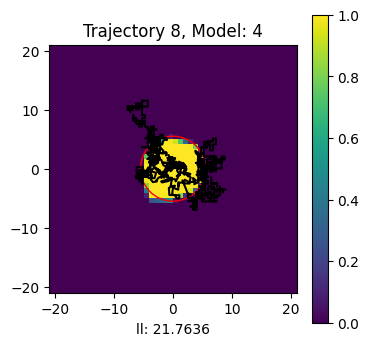

In [49]:
 plot_test(df, 8,4)